In [1]:
from itertools import product

import numpy as np
import xarray as xr
import pandas as pd
import geopandas
from shapely.geometry import Polygon, Point
import pyproj

%matplotlib inline
from matplotlib import pyplot as plt

#import xmitgcm as xm
from xmitgcm.llcreader import llcmodel as llc

import mitequinox.utils as ut

In [2]:
from dask.distributed import Client, LocalCluster
#
cluster = LocalCluster()
#
#from dask_jobqueue import PBSCluster
#cluster = PBSCluster(processes=4, cores=4, 
#                     walltime='04:00:00')
#cluster = PBSCluster()
#w = cluster.scale(jobs=1)
#
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:49126 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 56 Memory: 107.37 GB


---

# load data

In [3]:
ds = ut.load_data(V=['SST', 'SSU', 'SSV'])
grd = ut.load_grd()[['XC', 'YC', 'XG', 'YG']]
ds = xr.merge([ds, grd])

# downsample
ds = ds.isel(time=slice(0,24))
ds

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, time: 24)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    niter    (time) int64 dask.array<chunksize=(24,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2011-11-15 ... 2011-11-15T23:00:00
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    XC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XG       (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YG       (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dyG      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAw      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dxG      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAz      (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dxC      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rA       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAs      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dyC      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    SN       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    CS       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
Data variables:
    SST      (time, face, j, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    SSU      (time, face, j, i_g) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    SSV      (time, face, j_g, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>

In [4]:
mates = [['maskW', 'maskS'],
         ['TAUX', 'TAUY'], 
         ['SSU', 'SSV'],
         ['dxC', 'dyC'], 
         ['dxG', 'dyG'], 
         ['hFacW','hFacS'], 
         ['rAw', 'rAs'],
        ]
for m in mates:
    if m[0] in ds:
        ds[m[0]].attrs['mate'] = m[1]
        ds[m[1]].attrs['mate'] = m[0]
        print(m)

['SSU', 'SSV']
['dxC', 'dyC']
['dxG', 'dyG']
['rAw', 'rAs']


In [5]:
ds_rt = llc.faces_dataset_to_latlon(ds)

# store initial grid size
Ni, Nj = ds_rt.i.size, ds_rt.j.size

# add 1000 extra points along longitude to allow wrapping
N_extra = 1000
ds_extra = ds_rt.isel(i=slice(0, N_extra),i_g=slice(0, N_extra))
for dim in ['i', 'i_g']:
    ds_extra[dim] = ds_extra[dim] + ds_rt[dim][-1] + 1

ds_rt = xr.merge([xr.concat([ds_rt[v], ds_extra[v]], ds_rt[v].dims[-1]) for v in ds_rt])

In [6]:
ds_rt['SSV'].chunks

((1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1),
 (1, 4319, 1, 4319, 1, 4319),
 (4320, 4320, 4320, 4320, 1000))

In [7]:
ds_rt['SSV']

<xarray.DataArray 'SSV' (time: 24, j_g: 12960, i: 18280)>
dask.array<concatenate, shape=(24, 12960, 18280), dtype=float32, chunksize=(1, 4319, 4320), chunktype=numpy.ndarray>
Coordinates:
    niter    (time) int64 dask.array<chunksize=(24,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2011-11-15 ... 2011-11-15T23:00:00
  * i        (i) int64 0 1 2 3 4 5 6 ... 18274 18275 18276 18277 18278 18279
  * j_g      (j_g) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
    dxG      (j_g, i) float32 dask.array<chunksize=(1, 4320), meta=np.ndarray>
    rAs      (j_g, i) float32 dask.array<chunksize=(1, 4320), meta=np.ndarray>
    dyC      (j_g, i) float32 dask.array<chunksize=(1, 4320), meta=np.ndarray>
Attributes:
    long_name:      User-Defined V.vector Surface Diag. #10
    mate:           SSU
    standard_name:  SDIAG10
    units:          user-defined

In [8]:
ds_rt['SSV'].data

,Array,Chunk
Bytes,22.74 GB,74.63 MB
Shape,"(24, 12960, 18280)","(1, 4319, 4320)"
Count,233332 Tasks,720 Chunks
Type,float32,numpy.ndarray


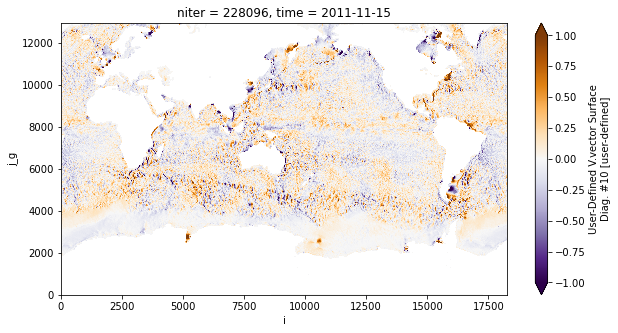

In [9]:
(ds_rt['SSV']
 .isel(time=0, i=slice(0,None,4), j_g=slice(0,None,4))
 .plot(vmin=-1, vmax=1, cmap='PuOr_r', figsize=(10,5))
)

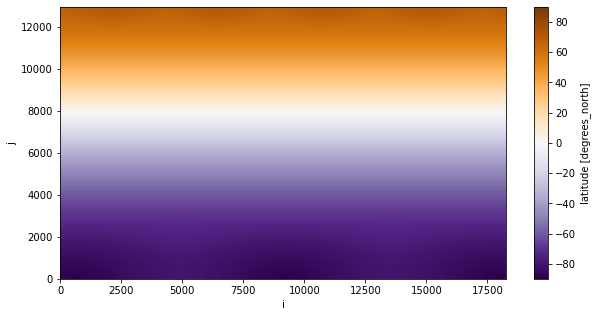

In [10]:
(ds_rt['YC']
 .isel(i=slice(0,None,4), j=slice(0,None,4))
 .plot(cmap='PuOr_r', figsize=(10,5))
)

---

## divide in overlapping faces and create geometric operators

In [11]:
def tile_domain(N, factor, overlap, wrap=False):
    if wrap:
        _N = N+overlap
    else:
        _N = N
    n = np.ceil((_N+(factor-1)*overlap)/factor)
    slices = []
    boundaries = []
    for f in range(factor):
        slices.append(slice(int(f*(n-overlap)), int(min(f*(n-overlap)+n, _N))))
        # boundaries do need to be exact
        lower = 0
        if f>0 or wrap:
            lower = int(f*(n-overlap)+0.5*overlap)
        upper = N
        if f<factor-1 or wrap:
            upper = int(f*(n-overlap)+n-0.5*overlap)
        boundaries.append(slice(lower, upper))
    return slices, boundaries
    
factor = (4, 4) # number of faces
overlap = (500,500) # number of points

tiles_1d, boundaries_1d = {}, {}
tiles_1d['i'], boundaries_1d['i'] = tile_domain(Ni, factor[0], overlap[0], wrap=True)
tiles_1d['j'], boundaries_1d['j'] = tile_domain(Nj, factor[0], overlap[0])

tiles = list(product(tiles_1d['i'], tiles_1d['j']))
boundaries = list(product(boundaries_1d['i'], boundaries_1d['j']))

N_tiles = len(tiles)

D = {'tiles': [ds_rt.isel(i=t[0], j=t[1], i_g=t[0], j_g=t[1]) for t in tiles], # will be used for parcel advections
     'boundaries': [ds_rt.isel(i=b[0], j=b[1], i_g=b[0], j_g=b[1]) for b in boundaries] # only bounds will be used
    }
# we need tile centers for geographic projections (dateline issues)
centers = [ds_rt.reset_coords()[['XC', 'YC']]
                .isel(i=[int((t[0].start+t[0].stop)/2)],
                      j=[int((t[1].start+t[1].stop)/2)]
                     )
                .squeeze()
           for t in tiles
          ]


slice(0, 4820, None) slice(250, 4570, None)
slice(4320, 9140, None) slice(4570, 8890, None)
slice(8640, 13460, None) slice(8890, 13210, None)
slice(12960, 17780, None) slice(13210, 17530, None)


Text(0.5, 0, 'i')

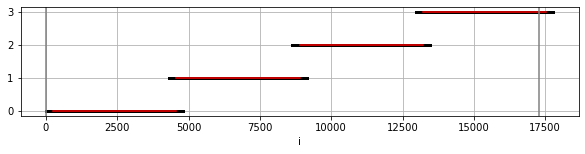

In [12]:
# plot 1D representations of boundaries

dim = 'i'

off = 1.
fig, ax = plt.subplots(1, figsize=(10,2))
i=0
for t, b in zip(tiles_1d[dim], boundaries_1d[dim]):
    print(t, b)
    ax.plot([t.start, t.stop], [off*i,off*i],'k', lw=3,)
    ax.plot([b.start, b.stop], [off*i,off*i],'r')
    i+=1

ax.axvline(x=0, color='0.5')
ax.axvline(x=dict(i=Ni, j=Nj)[dim], color='0.5')
ax.grid()
ax.set_xlabel(dim)

---

[geopandas clipping](https://geopandas.org/gallery/plot_clip.html#sphx-glr-gallery-plot-clip-py)

In [14]:
world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
crs_wgs84 = pyproj.CRS('EPSG:4326')

In [16]:
def get_boundary(da, i='i', j='j', stride=4):
    return np.hstack([da.isel(**{j:  0}).values[:: stride], 
                      da.isel(**{i: -1}).values[:: stride], 
                      da.isel(**{j: -1}).values[::-stride], 
                      da.isel(**{i:  0}).values[::-stride],
                     ])

In [17]:
# generate random points for testing
s = geopandas.GeoSeries([Point(lon, lat) for lon, lat in zip(np.random.uniform(0,180,(1000,)),
                                                             np.random.uniform(0,90,(1000,)),
                                                            )],
                        crs=crs_wgs84,
                       )

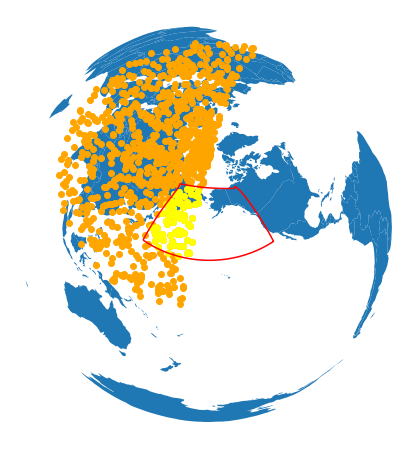

In [19]:
it = 11

d = D['boundaries'][it]
c = centers[it]

crs = pyproj.CRS("+proj=laea +lat_0={:d} +lon_0={:d} +units=m"
                 .format(int(c.YC), int(c.XC))
                )
#crs = pyproj.CRS("+proj=eqc +lat_ts=30 +lon_0=90w")
new_world = world.to_crs(crs)
#new_world.plot()

lon = get_boundary(d['XC'])
lat = get_boundary(d['YC'])

# generate a geopandas object in standard coordinates
_polygon = Polygon(list(zip(lon,lat)))
polygon_gdf = geopandas.GeoDataFrame([1], geometry=[_polygon], crs=crs_wgs84)
# transform coordinates to center around tiles
polygon_gdf.to_crs(crs, inplace=True)
# get shapely object back
polygon = polygon_gdf.geometry[0]

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
new_world.plot(ax=ax)
polygon_gdf.boundary.plot(ax=ax, color="red")

new_s = s.to_crs(crs)
new_s.plot(ax=ax, color='orange')

new_s_in_tile = new_s[new_s.within(polygon)]
new_s_in_tile.plot(ax=ax, color='yellow')

ax.set_axis_off()
plt.show()

In [20]:
# generate list of projections
CRS = [pyproj.CRS("+proj=laea +lat_0={:d} +lon_0={:d} +units=m"
                 .format(int(c.YC), int(c.XC)),
                )
      for i, c in enumerate(centers)]

In [21]:
CRS[0]

<Projected CRS: +proj=laea +lat_0=-78 +lon_0=15 +units=m +type=crs>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Lambert Azimuthal Equal Area
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [28]:
# build geometrical boundaries geopandas objects from boundaries
S, G = {}, {}
for key, _D in D.items():

    S[key] = []
    G[key] = []
    
    for d, crs in zip(_D, CRS):
    
        lon = get_boundary(d['XC'])
        lat = get_boundary(d['YC'])
        
        _polygon = Polygon(list(zip(lon,lat)))
        polygon_gdf = (geopandas.GeoDataFrame([1], geometry=[_polygon], crs=crs_wgs84)
                       .to_crs(crs)
                      )
        polygon = polygon_gdf.geometry[0]
        S[key].append(polygon)
        G[key].append(polygon_gdf)

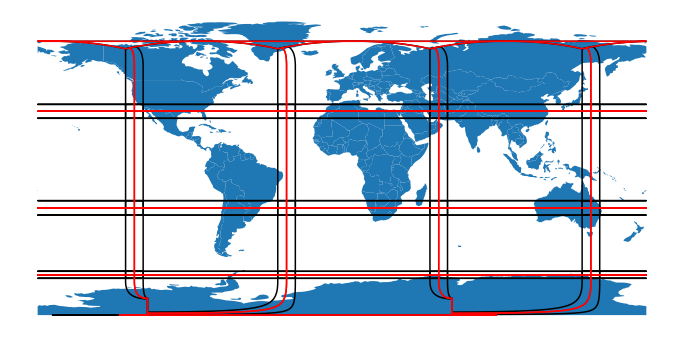

In [29]:
crs = crs_wgs84
new_world = world.to_crs(crs)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
new_world.plot(ax=ax)
for t in G['tiles']:
    t.to_crs(crs).boundary.plot(ax=ax, color="black")
for b in G['boundaries']:
    b.to_crs(crs).boundary.plot(ax=ax, color="red")
ax.set_axis_off()
plt.show()

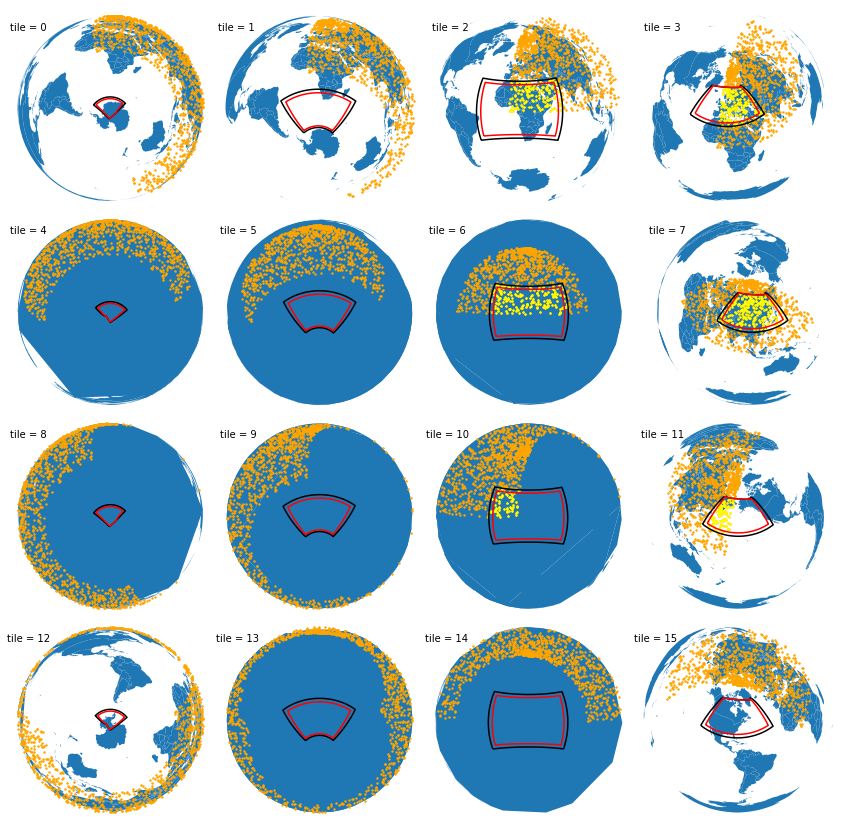

In [105]:
fig = plt.figure(figsize=(15, 15), constrained_layout=False)
grid = fig.add_gridspec(int(N_tiles/4), 4, wspace=0.0, hspace=0.0)

ms = 2

i=0
for t, b, crs in zip(G['tiles'], G['boundaries'], CRS):
    ax = fig.add_subplot(grid[int(i/4), i % 4]) 
    
    new_world = world.to_crs(crs)
    new_world.plot(ax=ax)
    
    t.boundary.plot(ax=ax, color="black")
    b.boundary.plot(ax=ax, color="red")

    new_s = s.to_crs(crs)
    new_s_in_tile = new_s[new_s.within(t.geometry[0])]

    new_s.plot(ax=ax, markersize=ms, color='orange')
    if new_s_in_tile.size>0:
        new_s_in_tile.plot(ax=ax, markersize=ms, color='yellow')

    ax.text(0.1, 0.9, 'tile = {}'.format(i),
            horizontalalignment='center',
            verticalalignment='center',
            transform = ax.transAxes)
    ax.set_axis_off()
    
    i+=1

plt.show()    

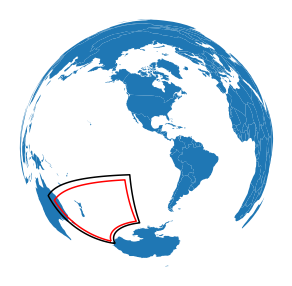

In [127]:
# plotting issues around the dateline ...

i=9
crs = crs_wgs84
crs = CRS[i]
crs = crs = pyproj.CRS("+proj=laea +lat_0={:d} +lon_0={:d} +units=m".format(0, -100))

new_world = world.to_crs(crs)

fig, ax = plt.subplots(1, 1, figsize=(5,5))
new_world.plot(ax=ax)
if True:
    t=G['tiles'][i]
    t.to_crs(crs).boundary.plot(ax=ax, color="black")
    b=G['boundaries'][i]
    b.to_crs(crs).boundary.plot(ax=ax, color="red")
ax.set_axis_off()
plt.show()

In [64]:
# determiner in which tile each point is located
df = pd.DataFrame([s.to_crs(crs).within(b) for b, crs in zip(S['boundaries'], CRS)]).T

In [65]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
996,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
997,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
998,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False


In [101]:
tile_ids = df.columns.to_numpy()
def func(v):
    out = tile_ids[v]
    if out.size==0:
        return -1
    else:
        return out[0]
s_itiles = df.apply(func, axis=1)

---

To summarise, on need the following data in order to reassign parcels: `S['boundaries'], CRS`
All tile informations should be stored.
We will be lazy for now and pickle



---

In [13]:
cluster.close()